In [1]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
sys.path.append(os.pardir)
print(torch.__version__, torch.cuda.is_available())

1.10.2 False


In [4]:
train_x = pd.read_csv("KomiyamaData/trainingData1.csv").values
train_y = pd.read_csv("KomiyamaData/trainingLabel_undummied.csv").values
train_y = train_y[:, 1]

test_x = pd.read_csv("KomiyamaData/testData1.csv").values
test_y = pd.read_csv("KomiyamaData/testLabel_undummied.csv").values
test_y = test_x[:, 1]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
class R_LLGMN_Pytorch(nn.Module):
    def __init__(self, dim, classNum, stateNum, componentNum, dataLength):
        #　変数
        self.dim = dim
        self.classNum = classNum                        # クラス数
        self.stateNum = stateNum                        # 状態数
        self.componentNum = componentNum                # コンポーネント数
        self.dataLength = dataLength                             # 時系列長
        self.logSize = int(1 + dim * (dim + 3) / 2)     # 非線形変換後のベクトル数
        # 各層の初期化
        self.in1 = torch.ones((self.dataLength, self.logSize), dtype = torch.float32)
        self.out1 = torch.zeros((self.dataLength, self.logSize), dtype = torch.float32)
        self.in2 = torch.zeros((self.dataLength, self.classNum, self.stateNum, self.stateNum, self.componentNum), dtype = torch.float32)
        self.out2 = torch.zeros((self.dataLength, self.classNum, self.stateNum, self.stateNum, self.componentNum), dtype = torch.float32)
        self.in3 = torch.zeros((self.dataLength, self.classNum, self.stateNum, self.stateNum), dtype = torch.float32)
        self.out3 = torch.zeros((self.dataLength, self.classNum, self.stateNum, self.stateNum), dtype = torch.float32)
        self.in4 = torch.zeros((self.dataLength, self.classNum, self.stateNum), dtype = torch.float32)
        self.out4 = torch.zeros((self.dataLength, self.classNum, self.stateNum), dtype = torch.float32)
        self.in5 = torch.zeros((self.dataLength, self.classNum), dtype = torch.float32)
        self.out5 = torch.zeros((self.dataLength, self.classNum), dtype = torch.float32)
        
        super(R_LLGMN_Pytorch, self).__init__()
        # パラメータ
        self.weight = nn.Parameter(torch.ones((self.classNum, self.stateNum, self.stateNum, self.componentNum, self.logSize), dtype = torch.float32))
      

    # 順方向
    def forward(self, X):
        rho = 1e-5
        
        for t in range(self.dataLength):
            
            # ----第1層----
            x = X[t].reshape(dim, 1)
            a = x @ x.T
            
            # 1次の項
            for i in range(self.dim):
                self.in1[t][i+1] = X[t][i]
            # 2次の項
            for i in range(self.logSize - self.dim - 1):
                self.in1[t][i+self.dim+1] = a[np.triu_indices(self.dim)][i]
            self.out1[t] = self.in1[t]
            # ----第1層----
            
            for c in range(self.classNum):
                for k1 in range(self.stateNum):
                    for k in range(self.stateNum):
                        for m in range(self.componentNum):
                            # ----第2層----
                            self.in2[t][c][k1][k][m] = torch.sum(self.weight[c][k1][k][m].clone() * self.out1[t].clone())
                            self.out2[t][c][k1][k][m] = torch.exp(self.in2[t][c][k1][k][m].clone())
                            # ----第2層----

                        # ----第3層----
                        self.in3[t][c][k1][k] = torch.sum(self.out2[t][c][k1][k].clone())
                        if t == 0:
                            self.out3[t] = self.in3[t].clone()
                        else:
                            self.out3[t][c][k1][k] = self.out4[t-1][c][k1].clone() * self.in3[t][c][k1][k].clone()
                        # ----第3層----
                    
                    # ----第4層----
                    self.in4[t][c][k1] = torch.sum(self.out3[t][c][k1].clone())
                    
            F_NN = torch.sum(self.in4[t].clone())
            
            if F_NN != 0:
                self.out4[t] = self.in4[t].clone() / F_NN
            else: # エラー回避
                self.out4[t] = self.in4[t].clone() / rho
            # ----第4層----
            
            # ----第5層----
            for c in range(self.classNum):
                self.in5[t][c] = torch.sum(self.out4[t][c].clone())
            
            self.in5[t] = torch.sum(self.out4[t].clone(), axis=1)
            
            self.out5[t] = self.in5[t].clone()
            # ----第5層----
            y = self.out5[t].clone()
            return y


dim = 2
classNum = 4
stateNum = 2
componentNum = 2
dataLength = dataLength

model = R_LLGMN_Pytorch(dim, classNum, stateNum, componentNum, dataLength)
print(model)

epoch: 1 	 loss: 1.3356617176532746
epoch: 2 	 loss: 1.1937995558977128
epoch: 3 	 loss: 1.1407871389389037
epoch: 4 	 loss: 1.099619899392128
epoch: 5 	 loss: 1.0651768159866333
epoch: 6 	 loss: 1.0345618307590485
epoch: 7 	 loss: 1.0073749327659607
epoch: 8 	 loss: 0.9833410525321961
epoch: 9 	 loss: 0.9621126317977905
epoch: 10 	 loss: 0.9432734024524688
done.


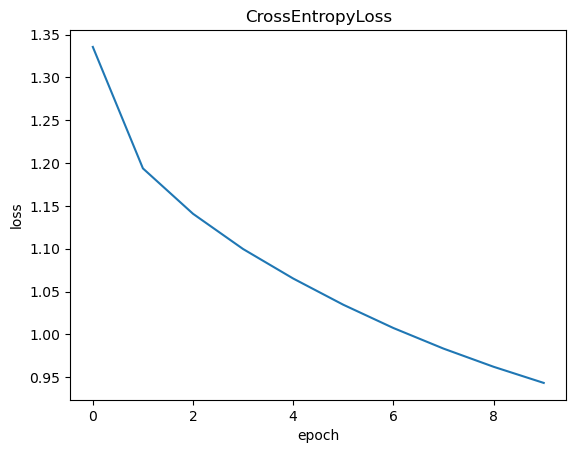

In [4]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

loss_record = []
epochs = 10

torch.autograd.set_detect_anomaly(True)
for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    for j, (X, label) in enumerate(zip(train_x, train_y)):
        y = model(X).view(-1, classNum)
        loss = loss_function(y, label)
        # print("time:{}, loss:{}".format(j, loss))
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    running_loss /= j+1
    loss_record.append(running_loss)
    print("epoch:", epoch, "\t", "loss:", running_loss)
print("done.")

plt.figure()
plt.plot(loss_record)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("CrossEntropyLoss")
plt.savefig("data1/loss.png")

In [5]:
import warnings
warnings.simplefilter('ignore')

predict_list = np.ones(len(test_y))
answer_list = np.ones(len(test_y))
predict_df = pd.DataFrame(columns=["answer", "predict", "exact"])
model.eval()
with torch.no_grad():
    for j, (X, label) in enumerate(zip(test_x, test_y)):
        y = model(X)
        predict = torch.argmax(y).to("cpu")
        predict = np.array(predict)
        predict_list[j] = predict 
        answer = np.array(label.item())
        answer_list[j] = answer
        exact = "O" if predict.item() == answer.item() else "X"
        s = pd.Series([answer, predict, exact], index=predict_df.columns)
        predict_df = predict_df.append(s, ignore_index=True)

print(predict_df.value_counts("exact"))
print(predict_df)

exact
O    100
dtype: int64
   answer predict exact
0       2       2     O
1       1       1     O
2       3       3     O
3       2       2     O
4       0       0     O
..    ...     ...   ...
95      1       1     O
96      1       1     O
97      0       0     O
98      1       1     O
99      3       3     O

[100 rows x 3 columns]


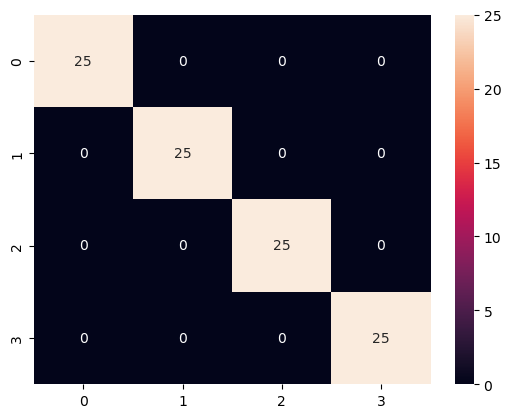

In [6]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

report = classification_report(answer_list, predict_list,output_dict= True)
pd_report = pd.DataFrame(report).transpose()
pd_report.to_csv("data1/report.csv")

matrix = confusion_matrix(answer_list, predict_list)
sns.heatmap(matrix, annot=True)
plt.savefig("data1/confusion_matrix.png")

In [7]:
# # label_0
# TP0 = 0
# FN0 = 0
# FP0 = 0
# TN0 = 0
# for ans, pred in zip(predict_df["answer"], predict_df["predict"]):
#     if (ans == 0 and pred == 0):
#         TP0 += 1
#     elif (ans == 0 and pred != 0):
#         FN0 += 1
#     elif (ans != 1 and pred == 0):
#         FP0 += 1
#     elif (ans != 0 and pred != 0):
#         TN0 += 1

        
# label_0 = 0     
# all_0 = (predict_df["answer"] == 0).sum()

# acc_0 = (TP0+TN0) / (TP0+TN0+FP0+FN0)

# recall_0 = TP0 / (TP0+FN0)

# pre_0 = TP0 / (TP0+FP0)

# F_0 = (2*recall_0*pre_0) / (recall_0+pre_0)

# score_0 = np.array([label_0, all_0, acc_0, recall_0, pre_0, F_0])
# print(score_0)



# # label_1
# TP1 = 0
# FN1 = 0
# FP1 = 0
# TN1 = 0
# for ans, pred in zip(predict_df["answer"], predict_df["predict"]):
#     if (ans == 1 and pred == 1):
#         TP1 += 1
#     elif (ans == 1 and pred != 1):
#         FN1 += 1
#     elif (ans != 1 and pred == 1):
#         FP1 += 1
#     elif (ans != 1 and pred != 1):
#         TN1 += 1

        
# label_1 = 1    
# all_1 = (predict_df["answer"] == 1).sum()

# acc_1 = (TP1+TN1) / (TP1+TN1+FP1+FN1)

# recall_1 = TP1 / (TP1+FN1)

# pre_1 = TP1 / (TP1+FP1)

# F_1 = (2*recall_1*pre_1) / (recall_1+pre_1)

# score_1 = np.array([label_1, all_1, acc_1, recall_1, pre_1, F_1])
# print(score_1)



# # # label_2
# TP2 = 0
# FN2 = 0
# FP2 = 0
# TN2 = 0
# for ans, pred in zip(predict_df["answer"], predict_df["predict"]):
#     if (ans == 2 and pred == 2):
#         TP2 += 1
#     elif (ans == 2 and pred != 2):
#         FN2 += 1
#     elif (ans != 2 and pred == 2):
#         FP2 += 1
#     elif (ans != 2 and pred != 2):
#         TN2 += 1

        
# label_2 = 2     
# all_2 = (predict_df["answer"] == 2).sum()

# acc_2 = (TP2+TN2) / (TP2+TN2+FP2+FN2)

# recall_2 = TP2 / (TP2+FN2)

# pre_2 = TP2 / (TP2+FP2)

# F_2 = (2*recall_2*pre_2) / (recall_2+pre_2)

# score_2 = np.array([label_2, all_2, acc_2, recall_2, pre_2, F_2])
# print(score_2)


# # # label_3
# TP3 = 0
# FN3 = 0
# FP3 = 0
# TN3 = 0
# for ans, pred in zip(predict_df["answer"], predict_df["predict"]):
#     if (ans == 3 and pred == 3):
#         TP3 += 1
#     elif (ans == 3 and pred != 3):
#         FN3 += 1
#     elif (ans != 3 and pred == 3):
#         FP3 += 1
#     elif (ans != 3 and pred != 3):
#         TN3 += 1

        
# label_3 = 3    
# all_3 = (predict_df["answer"] == 3).sum()

# acc_3 = (TP3+TN3) / (TP3+TN3+FP3+FN3)

# recall_3 = TP3 / (TP3+FN3)

# pre_3 = TP3 / (TP3+FP3)

# F_3 = (2*recall_3*pre_3) / (recall_3+pre_3)

# score_3 = np.array([label_3, all_3, acc_3, recall_3, pre_3, F_3])
# print(score_3)

# score_df = pd.DataFrame(np.vstack((score_0, score_1)),
#                        columns=["label", "all", "accuracy", "recall", "precision", "F-Score"])
# print(score_df)